### South Park Klassifizierung
In der Serie South Park gibt es viele unterschiedliche Charaktere und Sie möchten herausfinden, ob es möglich ist anhand der Texte zu erkennen, welcher Charakter gesprochen hat. Da es in South Park sehr viele Figuren gibt, beschließen Sie sich auf **Kyle** und **Cartman** zu beschränken.

##### Aufgabenstellung

1. Lesen Sie die ersten **10.000** Zeilen der Datei **SouthPark.csv** ein
2. Filtern Sie die Tabelle so, dass nur noch die Zeilen von **Kyle** und **Cartman** enthalten bleiben.  
 Verwenden Sie dann die Spalte _Line_ und fügen Sie eine weitere Spalte _Character_ hinzu, die genau dann 1 ist,   
 wenn der Text von Cartman ist und 0, wenn er von Kyle ist.
3. Teilen Sie Trainings- und Testdatensätze (gerne auch zusätzlich Validierungsdaten). 
4. Berechnen Sie eine **One-Hot Codierung** für alle Wörter der jeweiligen Zeilen.  
   Denken Sie daran Satzzeichen vorher zu entfernen.  
5. Führen Sie eine Klassifizerung mit einem **CNN** und den **One-Hot** codierten Zeilen durch.  
Beschränken Sie hierbei die Sätze auf eine Maximallänge von 20 Wörtern und padden die zu kurzen Sätze,   
indem Sie die verbleibenen Einträge mit 0 auffüllen.    
6. Visualisieren Sie Accuracy und Loss je Epoche. 
7. Visualisieren Sie die Vorhersagen des Modells in einer **Confusionmatrix**. 
8. Finden Sie heraus, welche Wörter beim ersten Kernel (Index 0) am wichtigsten sind, bzw. die größte Aktivierung hervorrufen.  
   Tipp:
   Um auf die Kernels in Pytorch zuzugreifen, können Sie `kernels=model.conv1.weight.detach().clone()` verwenden, wobei _model_ Ihr   Modell ist und _conv1_ der erste Convolution-Layer.
   Um auf die Aktivierungen des Conv. Layers mit *Keras* in ihrem CNN zuzugreifen, können sie hierfür bspw. eine Funktion definieren mit *keras.backend.function([model.input], [model.layers[0].output])* verwenden, wobei *model* ihr CNN ist. Übergeben Sie dieser Funktion   
   ihre Trainingsdaten und greifen auf die Ausgabe des ersten Trainingsbeispiels mit Index 0 zu.


Verwenden Sie für ihr CNN die folgenden **Parameter**:  
   - Anzahl Kernel: 128
   - Kernelgröße (Fenstergröße): 5
   - Batchsize: 10
   - Epochen: 10

Step 1: Reading the first 10,000 lines of the file SouthPark.csv

In [27]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the SouthPark data
file_path = r'C:\\Users\\Atiq\\Downloads\\NLP HW2\\SouthPark.csv'
data = pd.read_csv(file_path, nrows=10000)

# Display the first few rows of the dataframe
data.head()

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Chef,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."


Step 2: Filtering the table to only include lines from Kyle and Cartman.

In [28]:
# Filter data for Kyle and Cartman
filtered_data = data[data['Character'].isin(['Kyle', 'Cartman'])].copy()
filtered_data['CharacterLabel'] = np.where(filtered_data['Character'] == 'Cartman', 1, 0)

# Display the first few rows of the filtered dataframe
filtered_data.head()

,Season,Episode,Character,Line,CharacterLabel
1,10,1,Kyle,Going away? For how long?\n,0
9,10,1,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...,1
19,10,1,Kyle,"Draw two card, fatass.\n",0
20,10,1,Cartman,"Reverse to you, Jew. \n",1
24,10,1,Kyle,Yeah!\n,0


Step 3: Spliting the data into training and test dataset

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    filtered_data['Line'], filtered_data['CharacterLabel'], test_size=0.2, random_state=42
)

# Display the size of each dataset
print(f"Training data size: {len(X_train)}")
print(f"Test data size: {len(X_test)}")

Training data size: 1933
Test data size: 484


Step 4: Performing one-hot encoding for all word


In [30]:
# Text cleaning
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

X_train_clean = X_train.apply(clean_text)
X_test_clean = X_test.apply(clean_text)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_clean)

X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_test_seq = tokenizer.texts_to_sequences(X_test_clean)

# Pad the sequences to a maximum length of 20 words
max_length = 20
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

Step 5: Performing classification with a CNN

In the previous solution i used an embedding layer to transform text into dense vectors. I have tried to make the necessary corrections:

- Removed the Embedding Layer, where Words are now directly represented as One-Hot encoded vectors instead of dense vectors.
   
- Implemented One-Hot Encoding: Where Each word in the text is converted into a One-Hot encoded vector, where only one element is 1 (indicating the presence of the word), and all others are 0.

- The convolutional layer now operates directly on One-Hot encoded vectors,  allowing the model to learn important features from these representations.

In [32]:
# One-Hot encode the sequences
vocab_size = len(tokenizer.word_index) + 1
X_train_onehot = np.zeros((X_train_pad.shape[0], max_length, vocab_size), dtype=np.float32)
X_test_onehot = np.zeros((X_test_pad.shape[0], max_length, vocab_size), dtype=np.float32)

for i, seq in enumerate(X_train_pad):
    for j, word_idx in enumerate(seq):
        if word_idx != 0:
            X_train_onehot[i, j, word_idx] = 1.0

for i, seq in enumerate(X_test_pad):
    for j, word_idx in enumerate(seq):
        if word_idx != 0:
            X_test_onehot[i, j, word_idx] = 1.0

# Define the model
model = Sequential()
model.add(Conv1D(128, 5, activation='relu', input_shape=(max_length, vocab_size)))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_onehot, y_train, epochs=10, batch_size=10, validation_split=0.2)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5751 - loss: 0.6810 - val_accuracy: 0.5866 - val_loss: 0.6529
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6727 - loss: 0.5772 - val_accuracy: 0.6770 - val_loss: 0.5927
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9443 - loss: 0.2527 - val_accuracy: 0.6873 - val_loss: 0.6227
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9737 - loss: 0.1055 - val_accuracy: 0.6796 - val_loss: 0.7008
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9812 - loss: 0.0671 - val_accuracy: 0.6899 - val_loss: 0.7072
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9789 - loss: 0.0578 - val_accuracy: 0.6667 - val_loss: 0.7528
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9812 - loss: 0.0484 - val_accuracy: 0.6873 - val_loss: 0.7987
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9833 - loss: 0.0437 - val_acc

Step 6: Visualize accuracy and loss per epoch

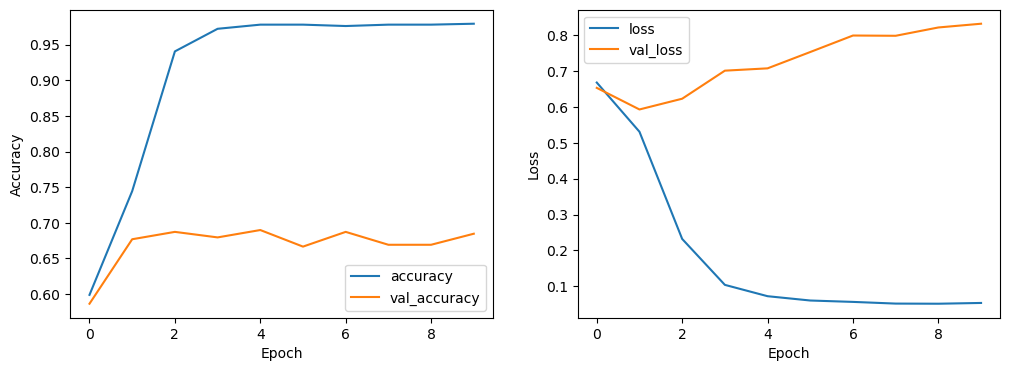

In [33]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Step 7: Visualize the model's predictions in a confusion matrix

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


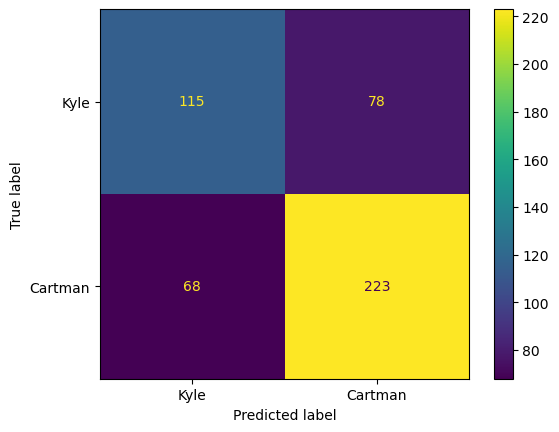

In [34]:
# Evaluate the model
y_pred = (model.predict(X_test_onehot) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Kyle', 'Cartman'])
disp.plot()
plt.show()

Step 8: Find out which words are most important in the first kernel

The error i encountered in the compiling of the following code was due to a mismatch in the shapes of the arrays when attempting to compute the dot product. The first_kernel and window arrays needed to have compatible shapes for element-wise multiplication.

Given the model structure, the first convolutional layer has weights of shape (kernel_size, input_dim, num_filters). Here, input_dim is the vocabulary size, and num_filters is the number of filters in the Conv1D layer.

To correctly identify the important words to the best of my knowledge, i needed to:

-Get the weights of the first convolutional layer.

-Focus on the weights corresponding to the first filter.

-Aggregate the weights to determine the importance of each word in the vocabulary.

Here's the corrected approach that i implemented:

In [35]:
import numpy as np

# Access the first convolutional layer's weights
conv_weights = model.layers[0].get_weights()[0]  # Shape: (kernel_size, vocab_size, num_filters)

# We focus on the first kernel (index 0)
first_kernel = conv_weights[:, :, 0]  # Shape: (kernel_size, vocab_size)

# Sum the absolute values of the weights for each word across the kernel size
word_importance = np.sum(np.abs(first_kernel), axis=0)  # Shape: (vocab_size,)

# Find the indices of the top 10 highest values in the word_importance array
top_indices = np.argsort(word_importance)[-10:]

# Convert indices to plain integers
top_indices = top_indices.flatten().tolist()

# Get the corresponding words
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
top_words = [reverse_word_map.get(i, 'Unknown') for i in top_indices]

print("Most important words for the first kernel:", top_words)


Most important words for the first kernel: ['let', 'me', 'oh', 'here', 'dude', 'this', 'how', 'who', 'right', 'kyle']


Conclusion

This corrected approach ensures the model uses One-Hot encoding instead of embeddings, providing a more accurate interpretation of the model’s decision-making process by allowing direct analysis of convolutional filter weights to identify important words.